In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import random

In [2]:
import numpy as np
from collections import namedtuple

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')
    
right = Action('right', 0, 0, 1)    
left = Action('left', 1, 0, -1)    
jump = Action('jump', 2, -2, 0)    
rightjump = Action('rightjump', 3, -2, 1)    
leftjump = Action('leftjump', 4, -2, -1)   
longrightjump = Action('longrightjump', 5, -2, 2)    
longleftjump = Action('longleftjump', 6, -2, -2)   


actions_move = {'right':(0,1),'left':(0,-1),'jump':(-2,0),'rightjump':(-2,1),'leftjump':(-2,-1),'longrightjump':(-2,2),'longleftjump':(-2,-2)}
# action_index = {'right':0,'left':1,'jump':2,'rightjump':3,'leftjump':4}


index_to_actions = {}
for action in [right, left, jump, rightjump, leftjump, longrightjump, longleftjump]:
    index_to_actions[action.index] = action

str_to_actions = {}
for action in [right, left, jump, rightjump, leftjump, longrightjump, longleftjump]:
    str_to_actions[action.name] = action

class Dangerous_Dave:
    
    def __init__(self):
        
        # Numpy array that holds the information about the environment
        self.level1_davegame = np.zeros((8, 17), dtype = np.int8)
        self.size = self.level1_davegame .shape
        
        # Bricks are obstacles
        self.level1_davegame [0, :] = 1
        self.level1_davegame [-1, :] = 1
        self.level1_davegame [:, 0] = 1
        self.level1_davegame [:, -1] = 1
        
#         self.level1_davegame  = np.zeros((8,17))
        self.level1_davegame [0,:] = 0
        self.level1_davegame [1,:] = 0
        self.level1_davegame [2,:] = 0
        self.level1_davegame [2,2::4] = 1
        self.level1_davegame [3,:] = 0
        self.level1_davegame [4,:] = 0
        self.level1_davegame [4,::4] = 1
        self.level1_davegame [5,:] = 0
        self.level1_davegame [6,:] = 0
        self.level1_davegame [6,3:7] = 1
        self.level1_davegame [6,11:16] = 1
        self.level1_davegame [7,:] = 0
        self.level1_davegame [7,11] = 1
        self.level1_davegame [7,0] = 1

        self.level1_davegame [5,0] = 2
        self.level1_davegame [3,0] = 2
        self.level1_davegame [1,2] = 2
        self.level1_davegame [1,6] = 2
        self.level1_davegame [1,14] = 2
        self.level1_davegame [3,4] = 2
        self.level1_davegame [3,8] = 2
        self.level1_davegame [3,12] = 2
        self.level1_davegame [3,16] = 2
        
        
                
        # initial position of the agent is always constant.
        self.position_agent = np.array((7,1))
        
        # run time
        self.time_elapsed = 0
        self.time_limit = self.size[0]*self.size[1]
        
        # display help
        self.dict_map_display={ 0:'.',
                                1:'X',
                                2:'D',
                                5:'K',
                                3:'E',
                                4:'A'}
        
        # position of the key
        self.position_exit = np.array((1,10))
        self.level1_davegame [self.position_exit[0], self.position_exit[1]] = 5
    

        
    
    
    def step(self, action):
        
        # At every timestep, the agent receives a negative reward
        reward = -1
        bump = False
        key_obtained = False
        
        def get_available_actions(state):
            available_actions = []
            for i in actions_move:
              ## Checks the surrounding of the agent's state and gets you the avialable moves
              if (state[0]+actions_move[i][0]) in range(self.level1_davegame .shape[0]) \
                and (state[1]+actions_move[i][1]) in range(self.level1_davegame .shape[1]) \
                and self.level1_davegame [(state[0]+actions_move[i][0],state[1]+actions_move[i][1])] != 1 :
                    ## Checks if there's a wall above the agent's head to prevent it from making a jump move
                    if ((self.level1_davegame [state[0]-1,state[1]] == 1) and (i in ['jump','rightjump','leftjump',
                                                                                     'longrightjump','longlefttjump'])) :
                        pass
                    else:
                        available_actions.append(i)
            return available_actions

        def gravity_update_state(move_state):
            ## Returns the same state if the agent is already standing on brick
            if move_state[0] == self.level1_davegame .shape[0]-1:
                return move_state
            ## Returns the state above the brick if the agent is in a higher state from the brick
            gravity_check = [(i,move_state[1]) for i in range(move_state[0],self.level1_davegame .shape[0])]
            for gravity in range(1,len(gravity_check)):
                if self.level1_davegame [gravity_check[gravity]] == 1 :
                    return gravity_check[gravity-1]
            return gravity_check[gravity]
    
    
        available_actions = get_available_actions((self.position_agent[0],self.position_agent[1]))
        
        if action in available_actions :
            move_state = (self.position_agent[0]+actions_move[action][0],
                          self.position_agent[1]+actions_move[action][1])
            next_position = gravity_update_state((move_state[0],move_state[1]))
            
        else:
            bump = True
            next_position = (self.position_agent[0],self.position_agent[1])
       
        # If the agent bumps into a brick, it doesn't move
        if self.level1_davegame [next_position[0], next_position[1]] == 1:
            bump = True
        else:
            self.position_agent = next_position
        
        # calculate reward
        current_cell_type = self.level1_davegame [self.position_agent[0], self.position_agent[1]]

        ## For reaching the diamond
        if current_cell_type == 2:
            self.level1_davegame [self.position_agent[0], self.position_agent[1]] = 0
            reward += self.size[0]*self.size[1]/4
        
        ## For reaching the door
        if current_cell_type == 3:
            reward += self.size[0]*self.size[1]

        ## For reaching the key
        if current_cell_type == 5:
            reward += self.size[0]*self.size[1]/2
            
        if bump:
            reward -= 20
        
        # calculate observations
        observations = self.calculate_observations()
        
        # update time
        self.time_elapsed += 1
        
        # verify termination condition
        done = False
        
        if self.time_elapsed == self.time_limit:
            done = True
        
        if (self.position_agent == self.position_exit).all():
            self.level1_davegame [self.position_exit[0], self.position_exit[1]] = 0
            self.position_exit = np.array((7,12))
            key_obtained = True

        if (self.position_agent == self.position_exit).all() and key_obtained==True:
            done = True
            

            key_obtained
        return observations, reward, done

    def display(self):
        
        envir_with_agent = self.level1_davegame .copy()
        envir_with_agent[self.position_agent[0], self.position_agent[1]] = 4
        
        full_repr = ""

        for r in range(self.size[0]):
            
            line = ""
            
            for c in range(self.size[1]):

                string_repr = self.dict_map_display[ envir_with_agent[r,c] ]
                
                line += "{0:2}".format(string_repr)

            full_repr += line + "\n"

        print(full_repr)

        
    def calculate_observations(self):
      
        relative_coordinates = self.position_exit - self.position_agent
                
        dungeon_padded = np.pad(self.level1_davegame , pad_width=2,constant_values=1)
        surroundings = dungeon_padded[self.position_agent[0] + 2 -2: self.position_agent[0]+ 2 +3,
                                             self.position_agent[1]+ 2 -2: self.position_agent[1]+ 2 +3]
        
        obs = {'relative_coordinates':relative_coordinates,
               'surroundings': surroundings}
               
        return obs
        
    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        It is common practice to return the observations, 
        so that the agent can decide on the first action right after the resetting of the environment.
        
        """
        self.time_elapsed = 0
        
        # position of the agent is a numpy array
        self.position_agent = np.array((7,1))
        
        # Calculate observations
        observations = self.calculate_observations()
        
        return observations

    
def run_single_exp(envir, policy):
    
    obs = envir.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        action = policy(obs)
        obs, reward, done = envir.step(action)
        
        total_reward += reward
    
    return total_reward

In [4]:
dave_level1 = Dangerous_Dave()
state = dave_level1.reset()
dave_level1.display()

. . . . . . . . . . . . . . . . . 
. . D . . . D . . . K . . . D . . 
. . X . . . X . . . X . . . X . . 
D . . . D . . . D . . . D . . . D 
X . . . X . . . X . . . X . . . X 
D . . . . . . . . . . . . . . . . 
. . . X X X X . . . . X X X X X . 
X A . . . . . . . . . X . . . . . 



In [ ]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:
def convert_state(state):
    
    c = state['relative_coordinates'].flatten()/17
    o = state['surroundings'].flatten()/4.
    state_tensor = np.concatenate( [c,o] )
    state_tensor = torch.tensor(state_tensor, device=device).unsqueeze(0)
    
    return state_tensor
    

class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = convert_state(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = convert_state(next_state)
            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        reward = torch.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.bn1 = nn.BatchNorm1d(size_hidden)
        
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.bn2 = nn.BatchNorm1d(size_hidden)

        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.bn3 = nn.BatchNorm1d(size_hidden)

        self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.bn1(self.fc1(x.float())))
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h3 = F.relu(self.bn3(self.fc3(h2)))
        output = self.fc4(h3.view(h3.size(0), -1))
        return output
    

In [ ]:
device

device(type='cuda')

In [ ]:
OBS_SIZE = 5*5 + 2
HIDDEN_SIZE = 128
ACTION_SIZE = 7

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 100

optimizer = optim.SGD(Q_network.parameters(), lr=0.1)
memory = ReplayMemory(10000)


In [ ]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                # index of the maximum over dimension 1.
                index_action = Q_network(state).max(1)[1].view(1, 1).cpu()[0][0].item()
                
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,6)
#             print(index_action)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

In [ ]:
BATCH_SIZE = 256
GAMMA = 0.5

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [ ]:
num_episodes = 1000

policy.reset()

rewards_history = []

# Warmup phase!
memory_filled = False

while not memory_filled:
    
    dave_level1 = Dangerous_Dave()
    state = dave_level1.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = dave_level1.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))
        
        state = next_state


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
    
for i_episode in range(num_episodes):
    
    # Same level at every run
    dave_level1 = Dangerous_Dave()
    state = dave_level1.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = dave_level1.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        started_training = True
        l = optimize_model()

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:

        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 10 == 0:
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(rewards_history[-10:])/10)    

print('Complete')

Done with the warmup
Episode  0 :  reward : -780.0 eps:  0.98703  loss: tensor(0.0149)
-78.0
Episode  10 :  reward : -454.0 eps:  0.9578156659018894  loss: tensor(0.0522)
-387.4
Episode  20 :  reward : -692.0 eps:  0.9294660241807036  loss: tensor(0.1410)
-464.2
Episode  30 :  reward : -278.0 eps:  0.9019554814785994  loss: tensor(0.0945)
-378.8
Episode  40 :  reward : -384.0 eps:  0.8752592019556485  loss: tensor(0.1045)
-391.8
Episode  50 :  reward : -204.0 eps:  0.8493530848686524  loss: tensor(0.1143)
-278.8
Episode  60 :  reward : -310.0 eps:  0.8242137428135844  loss: tensor(0.1236)
-280.4
Episode  70 :  reward : -358.0 eps:  0.79981848061202  loss: tensor(0.1164)
-216.0
Episode  80 :  reward : -390.0 eps:  0.776145274822487  loss: tensor(0.1657)
-213.4
Episode  90 :  reward : -312.0 eps:  0.7531727538582468  loss: tensor(0.1468)
-232.0
Episode  100 :  reward : -92.0 eps:  0.7308801786935519  loss: tensor(0.0927)
-201.0
Episode  110 :  reward : -190.0 eps:  0.7092474241409645  lo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


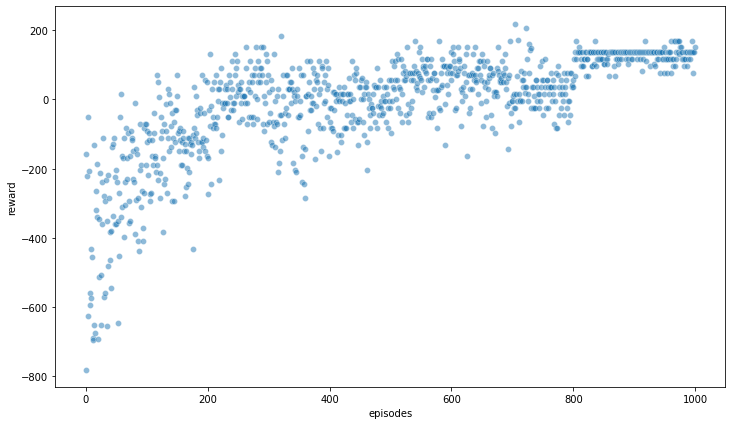

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,7))

ax = sns.scatterplot(x="episodes", y="reward", data=rewards_history,
           alpha=0.5);

In [ ]:
## Appendix
## Appendix
## Appendix

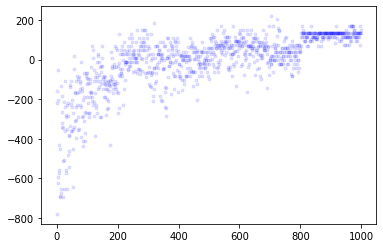

In [ ]:
plt.plot(rewards_history['dqn_rewardd'], 'b.', alpha=.1)

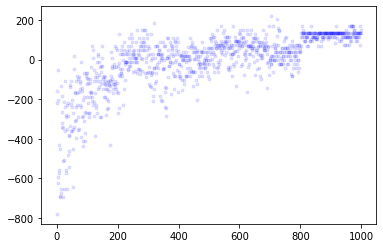

In [ ]:
plt.plot(rewards_history, 'b.', alpha=.1)

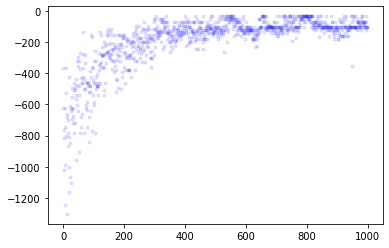

In [ ]:
plt.plot(rewards_history, 'b.', alpha=.1)

In [ ]:
class DQNMLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQNMLPModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.mlp = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU())
        self.fc_out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.view(x.size(0), self.input_size)
        h = self.mlp(x)
        return self.fc_out(h)

In [ ]:
OBS_SIZE = 5*5 + 2
HIDDEN_SIZE = 128
ACTION_SIZE = 7

Q_network = DQNMLPModel(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQNMLPModel(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.SGD(Q_network.parameters(), lr=0.1)
memory = ReplayMemory(10000)


In [ ]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                # index of the maximum over dimension 1.
                state = Variable(convert_state(state)/4. , volatile=True).unsqueeze(0)
                act_values = self.Qnet(state) 
                _ , index_action = act_values.data.max(1)
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,4)
#             print(index_action)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

In [ ]:
BATCH_SIZE = 256
GAMMA = 0.5

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros( BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)
    
    # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [ ]:


num_episodes = 1000

policy.reset()

DQNCNNModel_rewards_history = []

# Warmup phase!
DQNCNNModel_memory_filled = False

while not DQNCNNModel_memory_filled:
    
    dave_level1 = Dangerous_Dave()
    state = dave_level1.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = Variable(convert_state(state)/ 4. , volatile=True).unsqueeze(0)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = dave_level1.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = Nonea

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))
        
        state = next_state


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
    
for i_episode in range(num_episodes):
    
    # New dungeon at every run
    dave_level1 = Dangerous_Dave()
    state = dave_level1.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = dave_level1.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        started_training = True
        l = optimize_model()

    policy.update_epsilon()
    DQNCNNModel_rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:

        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 10 == 0:
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(DQNCNNModel_rewards_history[-10:])/10)    

print('Complete')

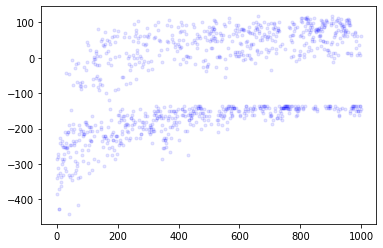

In [ ]:
plt.plot(rewards_history, 'b.', alpha=.1)

DQN(
  (fc1): Linear(in_features=27, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
dave_level1 = Dangerous_Dave()
state = dave_level1.reset()
convert_state(state)

tensor([[0.0000, 0.6471, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
         0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500]],
       device='cuda:0', dtype=torch.float64)

In [ ]:
Q_network

DQN(
  (fc1): Linear(in_features=27, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
def run_single_exp(envir, policy):
    
    obs = envir.reset()
    done = False
#     return obs
    total_reward = 0
    
    while not done:
        
        action = policy(convert_state(obs))
        print(action)
        obs, reward, done = envir.step(action)
        
        total_reward += reward
    
    return total_reward